## Import de Librerías

In [1]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.io import wavfile as wav
import pandas as pd
import os
import numpy as np
import seaborn as sns


from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

from statistics import mean,variance


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Creación del Dataset 

In [66]:
import numpy as np
import csv
from sklearn.datasets._base import Bunch

def num_target(target):
    
    if target == 'blues':
        return 0
    elif target == 'classical':
        return 1
    elif target == 'country':
        return 2
    elif target == 'disco':
        return 3
    elif target == 'hiphop':
        return 4
    elif target == 'jazz':
        return 5
    elif target == 'metal':
        return 6
    elif target == 'pop':
        return 7
    elif target == 'reggae':
        return 8
    else:
        return 9


def load_dataset():
    with open('C:/Users/Cartu/OneDrive/Documentos/GitHub/music_genre_classification/datasets/GTZAN_dataset.csv') as csv_file: # Path del dataset
        
        data_file = csv.reader(csv_file)
        
        temp = next(data_file)
        
        n_samples = 1000 
        n_features = 57
        
        feature_names = ['chroma_stft_mean','chroma_stft_var','rms_mean','rms_var','spectral_centroid_mean','spectral_centroid_var','spectral_bandwidth_var','spectral_bandwidth_mean','rolloff_mean','rolloff_var','zero_crossing_rate_mean','zero_crossing_rate_var','harmony_mean','harmony_var','perceptr_mean','perceptr_var','tempo','mfcc1_mean','mfcc1_var','mfcc2_mean','mfcc2_var','mfcc3_mean','mfcc3_var','mfcc4_mean','mfcc4_var','mfcc5_mean','mfcc5_var','mfcc6_mean','mfcc6_var','mfcc7_mean','mfcc7_var','mfcc8_mean','mfcc8_var','mfcc9_mean','mfcc9_var','mfcc10_mean','mfcc10_var','mfcc11_mean','mfcc11_var','mfcc12_mean','mfcc12_var','mfcc13_mean','mfcc13_var','mfcc14_mean','mfcc14_var','mfcc15_mean','mfcc15_var','mfcc16_mean','mfcc16_var','mfcc17_mean','mfcc17_var','mfcc18_mean','mfcc18_var','mfcc19_mean','mfcc19_var','mfcc20_mean','mfcc20_var'] 
        
        target_names = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock'] 
        
        data = np.empty((n_samples, n_features))
        target = np.empty((n_samples,), dtype=np.int)

        for i, sample in enumerate(data_file):
            data[i] = np.asarray(sample[:-1], dtype=np.float64)
            target[i] = np.asarray(num_target(sample[-1]), dtype=np.int)

    return Bunch(data=data, target=target, feature_names = feature_names, target_names = target_names)

data = load_dataset()


## Dataset GTZAN

In [67]:
df = pd.read_csv('C:/Jupyter Projects/Proyecto Final SYC/datasets/features_30_sec.csv') # Path del dataset
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516           213843.755497  ...   55.356403   
2              1747.702312            76254.192257  ...   40.598766   
3              1596.412872           166441.494769  ...   44.427753   
4              1748.172116            88445.209036  ...   86.099236   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.690215   36.524071    -0.408979   41.597103    -2.303523   55.062923   
1    -0.731125   60.314529     0.295073   48.120598    -0.283518   51.106190   
2    -7.729093   47.639427    -1.816407   52.382141    -3.439720   46.639660   
3    -3.319597   50.206673     0.636965   37.319130    -0.619121   37.259739   
4    -5.454034   75.269707    -0.916874   53.613918    -4.404827   62.910812   

   mfcc20_mean  mfcc20_var  label  
0     1.221291   46.936035  blues  
1     0.531217   45.786282  blues  
2    -2.231258   30.573025  blues  
3    -3.407448   31.949339  blues  
4   -11.703234   55.195160  blues  

[5 rows x 60 columns]

## Carga de Pista de Audio

In [68]:
audio_path = 'C:/Jupyter Projects/Proyecto Final SYC/Song_Samples/Autumn_Leaves.mp3' # Path de la canción
x , sr = librosa.load(audio_path, duration=30.0, offset=180)

C:\Users\Cartu\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


## Recolección de Propiedades

### Chroma Frequencies

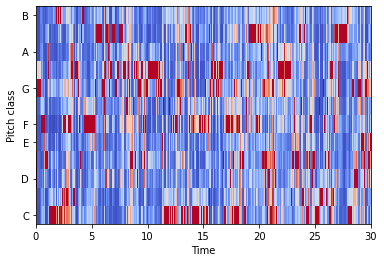

In [69]:
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=512)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')
chrm_mean = mean(chromagram.flatten())
chrm_var = variance(chromagram.flatten(), xbar=chrm_mean)

### Root Mean Square

C:\Users\Cartu\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Cartu\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Cartu\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


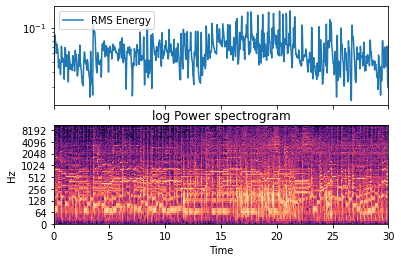

In [70]:
S, phase = librosa.magphase(librosa.stft(x))
rms = librosa.feature.rms(S=S)

fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')

rms_mean = mean(rms.flatten())
rms_var = variance(rms.flatten(), xbar=rms_mean)

### Spectral Centroid

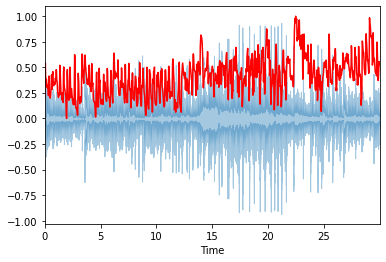

In [71]:
spectral_centroid = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroid.shape

t = librosa.frames_to_time(range(len(spectral_centroid)))

librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, preprocessing.minmax_scale(spectral_centroid,axis=0),color='r')

spectc_mean = mean(spectral_centroid.flatten())
spectc_var = variance(spectral_centroid.flatten(),xbar=spectc_mean)

### Spectral Bandwidth

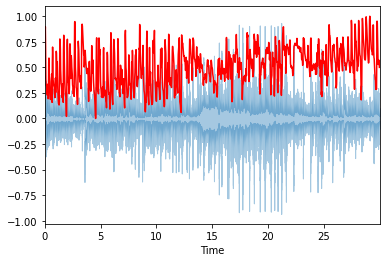

In [72]:
spectral_bandwidth = librosa.feature.spectral_bandwidth(x, sr=sr)[0]

librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, preprocessing.minmax_scale(spectral_bandwidth,axis=0),color='r')

spectbw_mean = mean(spectral_bandwidth.flatten())
spectbw_var = variance(spectral_bandwidth.flatten(),xbar=spectbw_mean)

### Spectral Rolloff

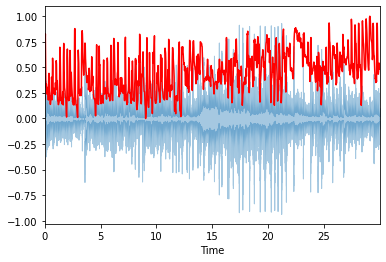

In [73]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]

librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, preprocessing.minmax_scale(spectral_rolloff,axis=0), color='r')

spectro_mean = mean(spectral_rolloff.flatten())
spectro_var = variance(spectral_rolloff.flatten(), xbar=spectro_mean)


### Zero Crossing Rate


 Number of crossings found: 8


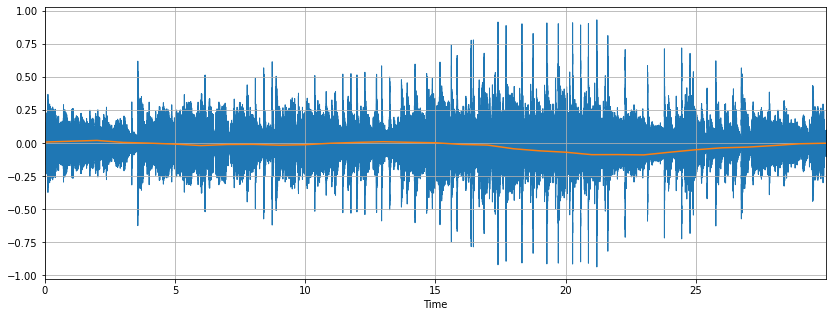

In [74]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(x, sr=sr)
plt.plot(x[9000:9100])
plt.grid()
zero_crossing = librosa.feature.zero_crossing_rate(x)


zeroc_mean = mean(zero_crossing.flatten())
zeroc_var = variance(zero_crossing.flatten(), xbar=zeroc_mean)

print(f'\n Number of crossings found: {sum(librosa.zero_crossings(x[9000:9100], pad=False))}')



### Harmonics and Perceptrual

-6.26549e-07
0.004483784164910681


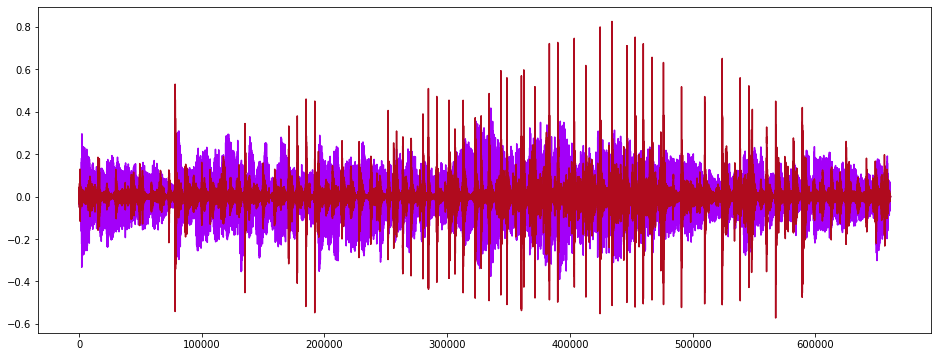

In [75]:
y_harm, y_perc = librosa.effects.hpss(x)

harm_mean = mean(y_harm)
harm_var = variance(y_harm, xbar=harm_mean)

perc_mean = mean(y_perc)
perc_var = variance(y_perc, xbar=perc_mean)

plt.figure(figsize=(16, 6))
plt.plot(y_harm, color = '#A300F9')
plt.plot(y_perc, color = '#B00B1E')

print(harm_mean)
print(harm_var)

### Tempo

In [76]:
onset_env = librosa.onset.onset_strength(x, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
print(tempo[0])

92.28515625


### Mel-Frequency Cepstral Coefficient

(20, 1292)


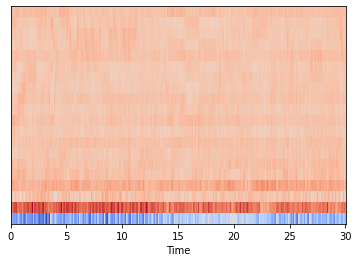

In [77]:
S = librosa.feature.melspectrogram(x, sr=sr, n_mels=128, fmax=8000)
mfcc_feat = librosa.feature.mfcc(x, sr=sr)
print(mfcc_feat.shape)

librosa.display.specshow(mfcc_feat, sr=sr, x_axis='time')

mfcc = {}


for i, mfccs in enumerate(mfcc_feat):
    mfcc['mfcc'+str(i+1)+'_mean'] = mean(mfccs.flatten())
    mfcc['mfcc'+str(i+1)+'_var'] = variance(mfccs.flatten(), xbar=mfcc['mfcc'+str(i+1)+'_mean'])    




In [80]:
X, y = data.data, data.target
knn = neighbors.KNeighborsClassifier(n_neighbors=19, weights='distance', metric='mahalanobis')
knn.fit(X,y)

X_pred = [chrm_mean, chrm_var, rms_mean, rms_var, spectc_mean, spectc_var, spectbw_mean, spectbw_var, spectro_mean, spectro_var, zeroc_mean, zeroc_var, harm_mean, harm_var, perc_mean, perc_var, tempo[0], ]

for value in mfcc.values():
    X_pred.append(value)


output = knn.predict([X_pred])


print ('Predicción de Género: ', data.target_names[output[0]])
print('Generos Posibles: ', data.target_names)
print ('Generos Posibles: ' ,  knn.predict_proba([X_pred]))

Predicción de Género:  jazz
Generos Posibles:  ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Generos Posibles:  [[0.0511446  0.05714777 0.16362523 0.1561482  0.         0.21280101
  0.05109387 0.1540371  0.         0.15400221]]
C:\Users\Cartu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\pairwise.py:1462: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  warnings.warn(
C:\Users\Cartu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\pairwise.py:1462: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  warnings.warn(
